In [33]:
import pandas as pd
import numpy as np
import plotly.express as px
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

## 1. Carga y lectura de datos

In [2]:
# Lectura de los datos
df = pd.read_excel('../data/Residential-Building-Data-Set.xlsx', sheet_name='Data', skiprows = 1)
df.head()

,START YEAR,START QUARTER,COMPLETION YEAR,COMPLETION QUARTER,V-1,V-2,V-3,V-4,V-5,V-6,...,V-22.4,V-23.4,V-24.4,V-25.4,V-26.4,V-27.4,V-28.4,V-29.4,V-9,V-10
0,81,1,85,1,1,3150.0,920.0,598.5,190,1010.84,...,815.50,1755.00,8002.0,60.74,54.26,2978.26,41407.0,601988.1,2200,410
1,84,1,89,4,1,7600.0,1140.0,3040.0,400,963.81,...,1316.30,8364.78,8393.0,90.95,89.79,11379.37,44835.0,929027.1,5000,1000
2,78,1,81,4,1,4800.0,840.0,480.0,100,689.84,...,765.80,1755.00,4930.0,38.70,32.04,1653.06,37933.0,377828.6,1200,170
3,72,2,73,2,1,685.0,202.0,13.7,20,459.54,...,152.25,1442.31,1456.0,9.73,8.34,686.16,8194.0,122031.7,165,30
4,87,1,90,2,1,3000.0,800.0,1230.0,410,631.91,...,2244.10,9231.76,9286.0,136.60,140.20,9821.00,48260.0,1734973.5,5500,700


In [3]:
# Se descartan las columnas de lags
first_columns = df.iloc[:, :31].columns.to_list() + ['V-9']
df = df[first_columns].copy()

## 2. Análisis Exploratorio de los Datos

### 2.1 Valores Faltantes

In [4]:
# Determinar si existen valores faltantes en el conjunto de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   START YEAR          372 non-null    int64  
 1   START QUARTER       372 non-null    int64  
 2   COMPLETION YEAR     372 non-null    int64  
 3   COMPLETION QUARTER  372 non-null    int64  
 4   V-1                 372 non-null    int64  
 5   V-2                 372 non-null    float64
 6   V-3                 372 non-null    float64
 7   V-4                 372 non-null    float64
 8   V-5                 372 non-null    int64  
 9   V-6                 372 non-null    float64
 10  V-7                 372 non-null    int64  
 11  V-8                 372 non-null    int64  
 12  V-11                372 non-null    float64
 13  V-12                372 non-null    float64
 14  V-13                372 non-null    float64
 15  V-14                372 non-null    float64
 16  V-15    

### 2.2 Matriz de Correlación
- Ideal para determinar que variables pueden ser importantes para el modelado predictivo y la toma de decisiones.

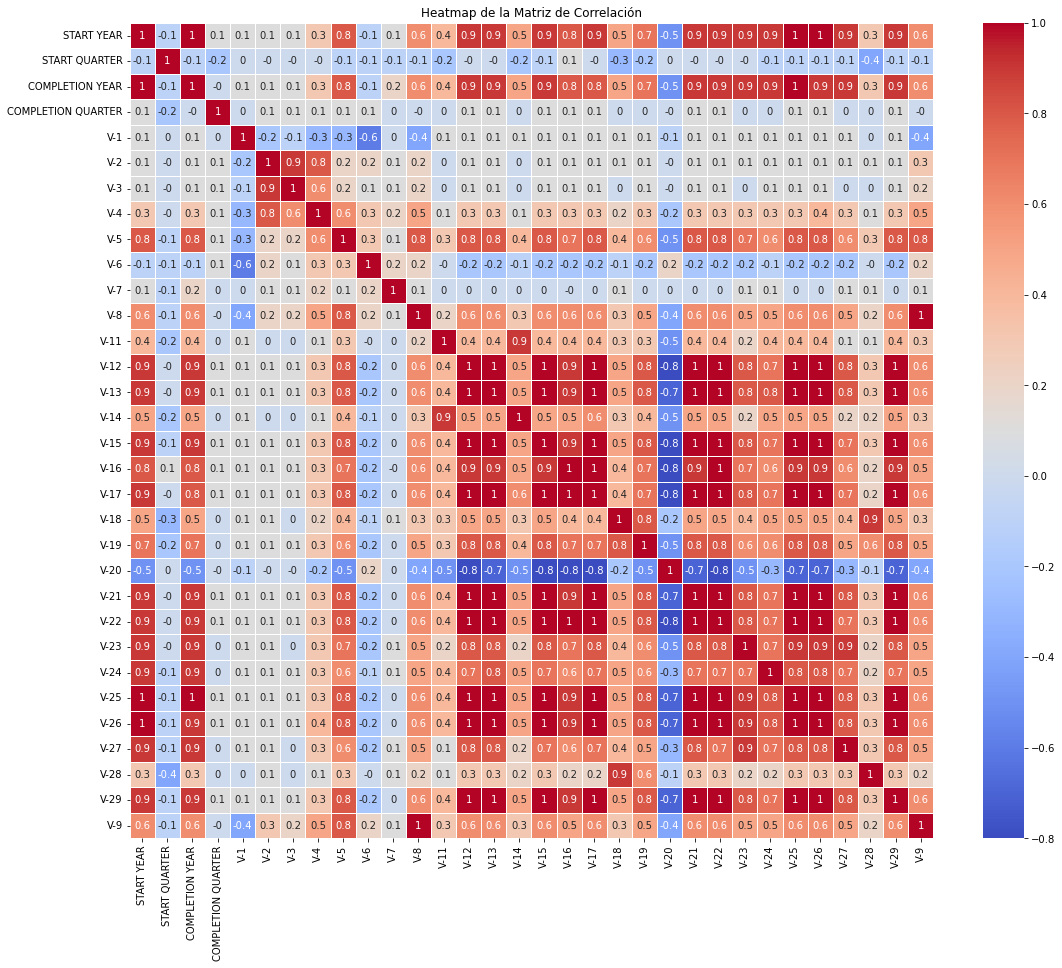

In [5]:
# Se obtiene la matriz de correlación
corr_matrix = round(df.corr(), 1)

# Mostrar matriz de manera visual
plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap de la Matriz de Correlación')
plt.show()

Se determinan las columnas a utilizar, las cuales son:
- V-2
- V-21
- V-22
- V-25
- V-26
- V-27

Variable a predecir: V-9

In [6]:
# Lista de columnas a usarr
cols = ['V-2', 'V-21', 'V-22', 'V-25', 'V-26', 'V-27', 'V-9']
data =  df[cols].copy()

In [7]:
data.head()

,V-2,V-21,V-22,V-25,V-26,V-27,V-9
0,3150.0,797.3,809.8,67.81,63.25,3758.77,2200
1,7600.0,1408.4,1473.5,105.52,105.32,12113.01,5000
2,4800.0,614.0,608.2,45.91,38.34,1537.96,1200
3,685.0,183.6,211.1,11.62,10.06,392.96,165
4,3000.0,2738.8,3148.0,158.63,169.50,10082.00,5500


### 2.3 Análisis de las variables
- Númericas

In [8]:
# Se cambia el nombre de las variables:
name_cols = ['Floor Area', 'Cost', 'Interest', 'CPI_BaseYear', 'CPI', 'Stock Market', 'Price']
data.columns = name_cols

In [9]:
# Con describe() se puede obtener un resumen rápido
data.describe()

,Floor Area,Cost,Interest,CPI_BaseYear,CPI,Stock Market,Price
count,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000
mean,1729.044355,1327.458353,1466.269247,88.380134,87.073978,6604.944973,1387.432796
std,1802.371491,868.491300,957.244634,45.774134,51.733900,4244.446452,1206.083047
min,200.000000,170.300000,211.100000,11.620000,10.060000,354.550000,50.000000
25%,720.000000,641.500000,744.500000,51.890000,42.870000,2134.490000,577.500000
50%,1220.000000,1023.700000,1203.300000,84.460000,81.470000,7334.780000,1000.000000
75%,2100.000000,1994.600000,2025.000000,123.370000,127.330000,10082.000000,1700.000000
max,15670.000000,4188.650000,4741.560000,204.700000,222.600000,13596.370000,6800.000000


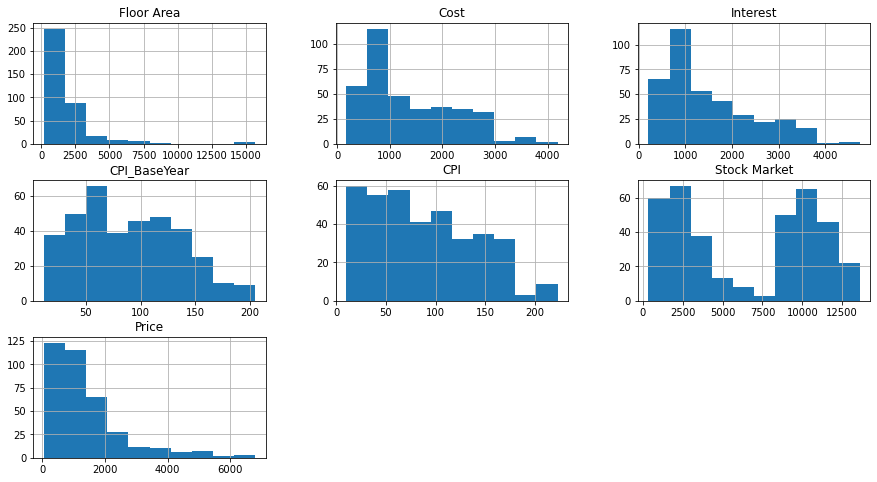

In [10]:
# Observar la distribución dee cada columna
data.hist(figsize=(15, 8))
plt.show()

In [11]:
# Calcular el valor de la asimetría para cada columna
for col in data.columns:
    print(f'Asimetría en {col}: {round(data[col].skew(), 2)}')

Asimetría en Floor Area: 3.99
Asimetría en Cost: 0.78
Asimetría en Interest: 0.96
Asimetría en CPI_BaseYear: 0.32
Asimetría en CPI: 0.42
Asimetría en Stock Market: -0.0
Asimetría en Price: 1.88


- Outliers

Boxplot Floor Area


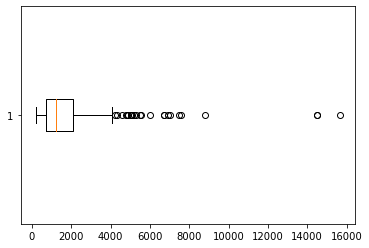

Boxplot Cost


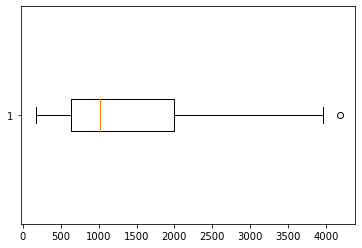

Boxplot Interest


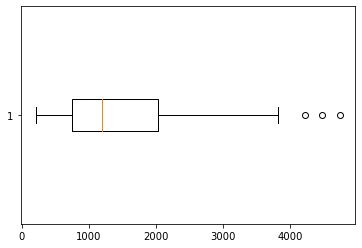

Boxplot CPI_BaseYear


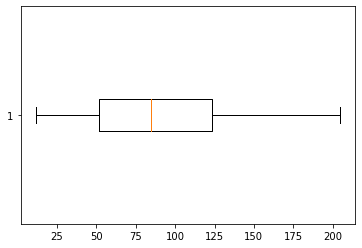

Boxplot CPI


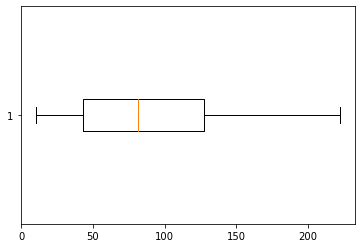

Boxplot Stock Market


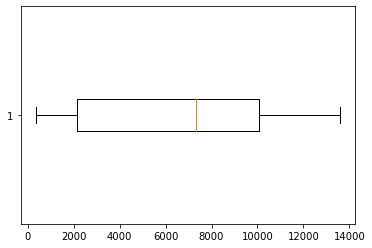

Boxplot Price


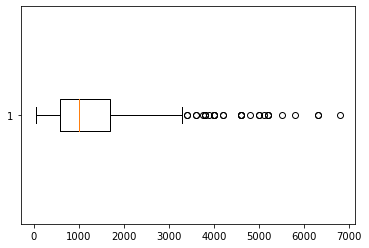

In [12]:
# Se muestran gráficos de bigote para entender los outliers
for col in data.columns:
    print(f'Boxplot {col}')
    plt.boxplot(data[col], vert=False)
    plt.show()

### 2.4 División de datos

In [13]:
X = data.drop('Price', axis = 1) 
y = data['Price'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(f'Shape: X_train {X_train.shape}')
print(f'Shape: X_test {X_test.shape}')


Shape: X_train (260, 6)
Shape: X_test (112, 6)


### 2.5 Transformación de Variables

In [14]:
# Se crea el transformador para las features y la variable objetivo
transformer = PowerTransformer(method='yeo-johnson')

pipeline = Pipeline([
    ('transformer', transformer),
])

# Aplicar la transformación
X_train_transformed = pipeline.fit_transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns = X.columns)

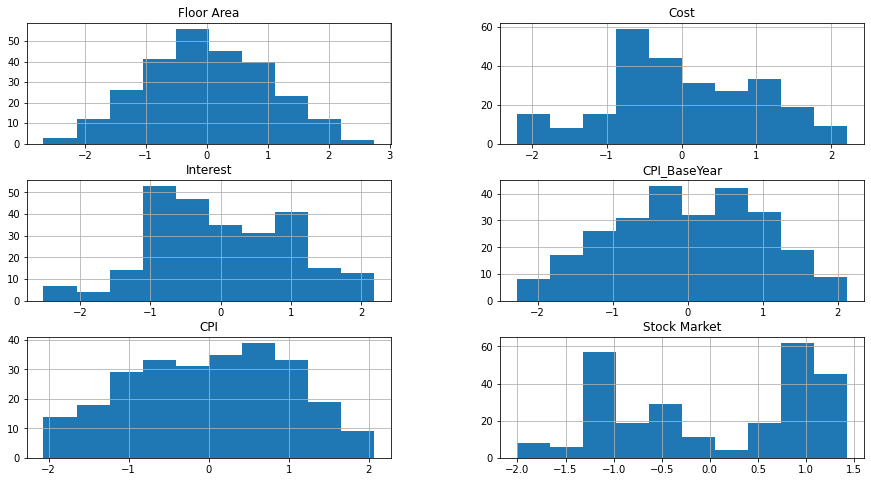

In [15]:
# Observar la distribución de cada columna
X_train_transformed.hist(figsize=(15, 8))
plt.show()

### 2.6 Comprobación de Valores Atípicos

Boxplot Floor Area


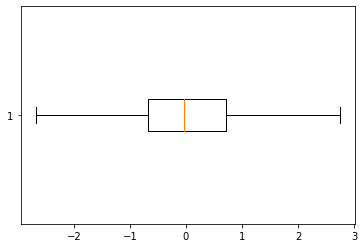

Boxplot Cost


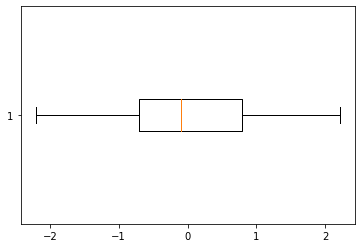

Boxplot Interest


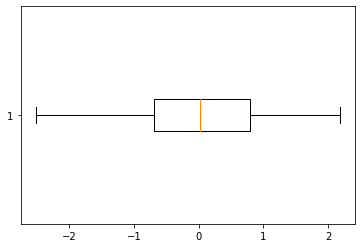

Boxplot CPI_BaseYear


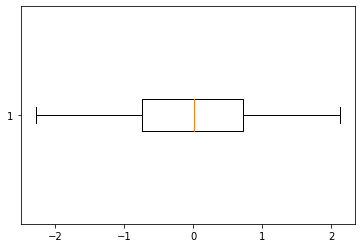

Boxplot CPI


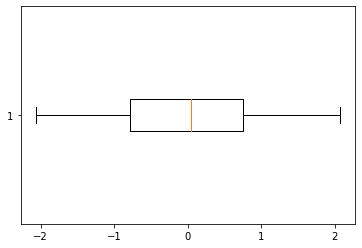

Boxplot Stock Market


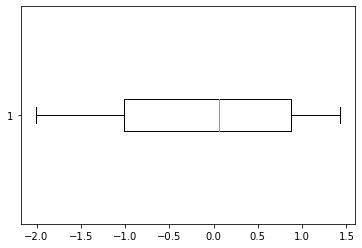

In [16]:
# Se muestran gráficos de bigote para entender los outliers
for col in X_train_transformed.columns:
    print(f'Boxplot {col}')
    plt.boxplot(X_train_transformed[col], vert=False)
    plt.show()

## 3. Modelado
- Se aplica un modelo de Machine Learning, en este caso se empieza con un modelo básico de regresión lineal

In [39]:
# Obtener features y definir variable objetivo
features = X_train.columns.to_list()
print(f'Features: {features}')

target = 'Price'
print(f'Objetivo: {target}')

# Se define un escalador robusto
scaler = StandardScaler()
# Se define un modelo de RL
model = LinearRegression()

Features: ['Floor Area', 'Cost', 'Interest', 'CPI_BaseYear', 'CPI', 'Stock Market']
Objetivo: Price


### 3.1 Feature Pipeline

In [40]:
# Pipeline
feature_pipeline = Pipeline([
    ('yeo_johnson', transformer),
    ('scaler', scaler)
])

column_transformer = ColumnTransformer(
    transformers=[
        ('features', feature_pipeline, features)
    ],
    remainder='passthrough'
)

model_pipeline = Pipeline([
    ('preprocessor', column_transformer),
    ('model', model)
])

### 3.2 Entrenamiento del modelo

In [41]:
# Se entrena el modelo con el conjunto de entrenamiento
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('features',
                                                  Pipeline(steps=[('yeo_johnson',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Floor Area', 'Cost',
                                                   'Interest', 'CPI_BaseYear',
                                                   'CPI', 'Stock Market'])])),
                ('model', LinearRegression())])

### 3.3 Validación Cruzada

In [42]:
# Validación cruzada K-fold
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, shuffle = True, random_state = 0)
cv_scores = cross_val_score(model_pipeline, X_train, y_train, cv = kf)

print("CV Promedio:", np.mean(cv_scores))

CV Promedio: 0.17697794644298867


### 3.4 Evaluación del Modelo

In [43]:
test_score = model_pipeline.score(X_test, y_test)
print("Test score:", test_score)

y_pred = model_pipeline.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

Test score: 0.4397326439329854
RMSE: 1028.7132081181242
